In [1]:
# from analyse import prepare_data
import matplotlib.pyplot as plt
import numpy as np
from analyse import extract_data, get_keys
from statistics import stdev, mean

# import jtplot submodule from jupyterthemes
# from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
# jtplot.style()

In [2]:
default_fig_size = [14, 10]
extended_fig_size = [30, 100]
plt.rcParams['figure.figsize'] = default_fig_size
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 150
# print

In [3]:
data_type = 'latest_sbs'
data_folder = f'/home/serchio/Documents/COAT/lora_wakeup/data/{data_type}'
# experiments = [
#     'sx1262_optimal', 'sx1262_nbs', 'sx1262_performance', 'sx1262_join', 'sx1262_dcw2', 'sx1262_dcw3', 'sx1262_dcw4'
# ]
experiments = ['sx1262_optimal', 'sx1262_performance', 'sx1262_dcw4']
# opt_folder, nbs_folder, perf_folder, join_folder, dcw_folder, dcw2_folder, dcw3_folder = [
opt_folder, perf_folder, dcw3_folder = [
    f'{data_folder}/{x}' for x in experiments
]
energy_opt, stats_opt, info_opt = extract_data(opt_folder, new_format=True)
# energy_nbs, stats_nbs, info_nbs = extract_data(nbs_folder, new_format=True)
energy_perf, stats_perf, info_perf = extract_data(perf_folder, new_format=True)
# energy_join, stats_join, info_join = extract_data(join_folder, new_format=True)
# energy_dcw, stats_dcw, info_dcw = extract_data(dcw_folder, new_format=True)
# energy_dcw2, stats_dcw2, info_dcw2 = extract_data(dcw2_folder, new_format=True)
energy_dcw3, stats_dcw3, info_dcw3 = extract_data(dcw3_folder, new_format=True)

In [4]:
def get_avg_joules(data, keys):
    gw = []
    eds = []
    eds_stdev = []
    for key in keys:
#         tmp_key_data = data[key]
        gw.append(data[key][0][0])
        key_eds = [data[key][x][0] for x in data[key] if x >= 1]
        if len(key_eds) > 1:
            eds.append(mean(key_eds))
            eds_stdev.append(stdev(key_eds))
        else:
            eds.append(key_eds[0])
            eds_stdev.append(0.0)
        
    return gw, eds, eds_stdev

def prepare_labels(keys, info):
    labels = []
    for key in keys:
        if key.find('lorawan') >= 0:
            labels.append(f'LoRaWAN: 1 x ED\nTd = {info[key]["delay"]}s')
            continue
            
        nr_dev = key.split('_')[2]
#         labels.append(f'CoLoRa: {nr_dev} x EDs\nTd = {info[key]["delay"]}s, Tdw = {info[key]["dw"]}s, Tdcw = {info[key]["dcw"]}s')
        labels.append(f'CoLoRa: {nr_dev} x ED\nTd = {info[key]["delay"]}s')
        
    return labels

In [5]:
def plot_overview(labels, legend, data, x_label, y_label=None, sub=False, std=None):
    import math
    from matplotlib.lines import Line2D
    f_size = 20

    if sub:
        l_legend = legend[0]
        l_data = data[0]
        legend = legend[1:]
        data = data[1:]
    
    x = np.arange(len(labels))  # the label locations
    x = labels  # the label locations
    
    styles = ['v--', 'o--', '^--', 's--', 'D--', 'p--'] + ['p--' for x in range(0, 20)]
    fig, ax = plt.subplots()
    for i in range(0, len(data)):
        ax.plot(x, data[i], styles.pop(), label=legend[i], markersize=8)
        if std is not None:
#             plt.errorbar(x, data[i], std[i], linestyle='None', marker='^')
            plt.errorbar(x, data[i], yerr=std[i], fmt='none', ecolor='black', elinewidth=1, capsize=2)
    
    if sub:
        ins = ax.inset_axes([0.37,0.73,0.3,0.23])
        ins.set_xticks([x for x in range(0, 1024 + 128, 1024)])
        ins.set_xticklabels([f'{x}KB' for x in range(0, 1024 + 128, 1024)])
        ins.plot([0, 1024], [l_data, l_data], 'k-')
#         ins.set_yticks()
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    if y_label is not None:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel('Estimated energy consumption [Joules]')

    ax.set_xlabel(x_label)
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks([x for x in range(128, 1024 + 128, 128)])
    lim = ax.get_ylim()
    if lim[1] > 15000:
        max_y = math.floor(lim[1] / 5000) * 5000
        ax.set_yticks([x for x in range (0, max_y + 5000, 5000)])
        for label in ax.yaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    ax.set_xticklabels([f'{x}KB' for x in range(128, 1024 + 128, 128)])
#     ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    if sub:
        line = Line2D([0], [0], color='k', lw=2, linestyle='-', label=l_legend)
        # manually define a new patch 
#         patch = mpatches.Patch(color='grey', label='Manual Label')
        # handles is a list, so append manual patch
        handles.append(line) 
#     ax.set_yscale('log')
    ax.legend(handles=handles, fontsize=f_size)
#     ax.legend(fontsize=f_size)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2)


#     autolabel(rects1)
#     autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
def plot_overview_bars_eds(labels, legend, data, x_label, y_label=None, max_y=None):
    f_size = 20
    
    x = np.arange(len(labels))  # the label locations
    width = 0.9  # the width of the bars
    fig, ax = plt.subplots()

    n_bars = len(legend)
    reacts = []
    diff = 1
    middle_bar = []
    if n_bars % 2 == 0:
        middle_bar.append(n_bars / 2 - 1)
        middle_bar.append(n_bars / 2)
        n = 1.5
        d = 2
        minus = True
    else:
        middle_bar.append(int(n_bars / 2))
        n = 1
        d = 1
        minus = None
        
    for i in range(0, n_bars):
        if i < (n_bars / 2) - 1:
            tmp_n = (int(n_bars / 2) - d - i) * diff + n
            reacts.append(ax.bar(x - width/n_bars*tmp_n, data[i], width/n_bars, label=legend[i]))
        elif i in middle_bar:
            pos = (x - width/n_bars/2) if minus else x if minus is None else (x + width/n_bars/2)
            reacts.append(ax.bar(pos, data[i], width/n_bars, label=legend[i]))
            minus = False
        else:
            tmp_n = (i - int(n_bars / 2) - 1) * diff + n
            reacts.append(ax.bar(x + width/n_bars*tmp_n, data[i], width/n_bars, label=legend[i]))

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.legend(fontsize=f_size, loc='upper left')
    ax.grid(True)
    
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if int(round(height, 0)) == 0.0:
                continue
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 6 * 3, height),
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(1, 4),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 6, rotation=90)

    for react in reacts:
        autolabel(react)
    
    colors = []
    for i in range(0, len(reacts)):
        colors.append(reacts[i][0].get_facecolor())

    plt.show()
    return colors
    
def plot_overview_bars_gws(labels, legend, data, x_label, y_label, colors, max_y=None, sep_lwan=True, log_scale=False):
    from matplotlib.patches import Patch
    f_size = 20
    
    x = np.arange(len(labels))  # the label locations
    width = 0.9  # the width of the bars
    fig, ax = plt.subplots()
    handles = []
    for l in range(0, len(legend)):
        patch = Patch(color=colors[l], label=legend[l])
        handles.append(patch)
    
#     if sep_lwan:
    ax.legend(handles=handles, fontsize=f_size-4)
#     else:
#     ax.legend(handles=handles, fontsize=f_size, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
#     n_bars = len(legend) - 1
    n_bars = len(legend)
    reacts = []
    diff = 1
    middle_bar = []
    if n_bars % 2 == 0:
        middle_bar.append(n_bars / 2 - 1)
        middle_bar.append(n_bars / 2)
        n = 1.5
        d = 2
        minus = True
    else:
        middle_bar.append(int(n_bars / 2))
        n = 1
        d = 1
        minus = None
    
    range_start = 1 if sep_lwan else 0
    for i in range(range_start, n_bars):
        if i < (n_bars / 2) - 1:
            tmp_n = (int(n_bars / 2) - d - i) * diff + n
            reacts.append(ax.bar(x - width/n_bars*tmp_n, data[i], width/n_bars, label=legend[i], color=colors[i]))
        elif i in middle_bar:
            pos = (x - width/n_bars/2) if minus else x if minus is None else (x + width/n_bars/2)
            reacts.append(ax.bar(pos, data[i], width/n_bars, label=legend[i], color=colors[i]))
            minus = False
        else:
            tmp_n = (i - int(n_bars / 2) - 1) * diff + n
            reacts.append(ax.bar(x + width/n_bars*tmp_n, data[i], width/n_bars, label=legend[i], color=colors[i]))
        
#     ins = ax.inset_axes([0.4,0.67,0.05,0.23])
    if sep_lwan:
#         ins = ax.inset_axes([0.4,0.67,0.2,0.23])
        ins = ax.inset_axes([0.435,0.73,0.2,0.23])
        ins.set_xticks([1, 2, 3, 4])
        ins.set_xticklabels(labels)
        ins.bar([1], data[0], width/2, color=colors[0])
        ins.bar([2], data[0], width/2, color=colors[0])
        ins.bar([3], data[0], width/2, color=colors[0])
        ins.bar([4], data[0], width/2, color=colors[0])
        ins_y_labels = []
        ins_y = ins.get_yticks()
        for y in ins_y:
            if y == 0:
                ins_y_labels.append(f'0')
                continue
            ins_y_labels.append(f'{int(y / 1000000)}M')
        ins.set_yticks(ins_y)
        ins.set_yticklabels(ins_y_labels)
        ins.grid(True)
        
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.grid(True)
    if log_scale:
        ax.set_yscale('log')
    
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if int(round(height, 0)) == 0.0:
                continue
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 6 * 3, height),
                        xytext=(1, 4),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 6, rotation=90)

    for react in reacts:
        autolabel(react)
    
    plt.show()

In [6]:
class KeysWrapper():
    def __init__(self, folder, number_of_devs=60, step=5, starting_number=1, seq=[]):
        self.keys = []
        self.devs = []
        self.nod = number_of_devs
        self.step = step
        self.sn = starting_number
        self.folder = folder
        self.seq = seq
    
    def get_keys(self, prefix):
        self.keys, self.devs = get_keys(self.folder, prefix, max_nr_of_devs=self.nod, devs_step=self.step, starting_dev=self.sn, seq=self.seq)
        self.nod = int(self.devs[-1])
        return self.keys

kp = KeysWrapper(opt_folder, seq=[1, 5, 10, 20, 30, 40, 50, 60])
    
keys_128 = ['lorawan_128_1'] + kp.get_keys('colora_128')
keys_256 = ['lorawan_256_1'] + kp.get_keys('colora_256')
keys_512 = ['lorawan_512_1'] + kp.get_keys('colora_512')
keys_1024 = ['lorawan_1024_1'] + kp.get_keys('colora_1024')
keys_128_2 = ['lorawan_sx1262_128_1'] + kp.get_keys('colora_128')
keys_256_2 = ['lorawan_sx1262_256_1'] + kp.get_keys('colora_256')
keys_512_2 = ['lorawan_sx1262_512_1'] + kp.get_keys('colora_512')
keys_1024_2 = ['lorawan_sx1262_1024_1'] + kp.get_keys('colora_1024')

# legend = [f'LoRaWAN: {kp.nod} ED'] + [f'CoLoRa: {x} CN' for x in kp.devs]
legend = [f'LW: {kp.nod} EN'] + [f'C: {x} CN' for x in kp.devs]
labels = [128, 256, 512, 1024]

def prepare_data_for_comparison(keys_128, keys_256, keys_512, keys_1024):
    keys = []
    for i in range(0, len(keys_128)):
        k = []
        k.append(keys_128[i])
        k.append(keys_256[i])
        k.append(keys_512[i])
        k.append(keys_1024[i])
        keys.append(k)

    gw = []
    dev = []
    dev_std = []
    delay = []
    for key in keys:
        t_gw, t_dev, t_dev_std = get_avg_joules(energy_opt, key)
        gw.append(t_gw)
        dev.append(t_dev)
        dev_std.append(t_dev_std)
        t_delay = [info_opt[x]['delay'] for x in key]
        delay.append(t_delay)
        
    return gw, dev, dev_std, delay

In [7]:
gw, dev, dev_std, delay = prepare_data_for_comparison(keys_128, keys_256, keys_512, keys_1024)
gw_2, dev_2, dev_std_2, delay_2 = prepare_data_for_comparison(keys_128_2, keys_256_2, keys_512_2, keys_1024_2)

# Energy EDs

### LoRaWAN GW -> ic880a_4paths

9
9
[128, 256, 512, 1024]


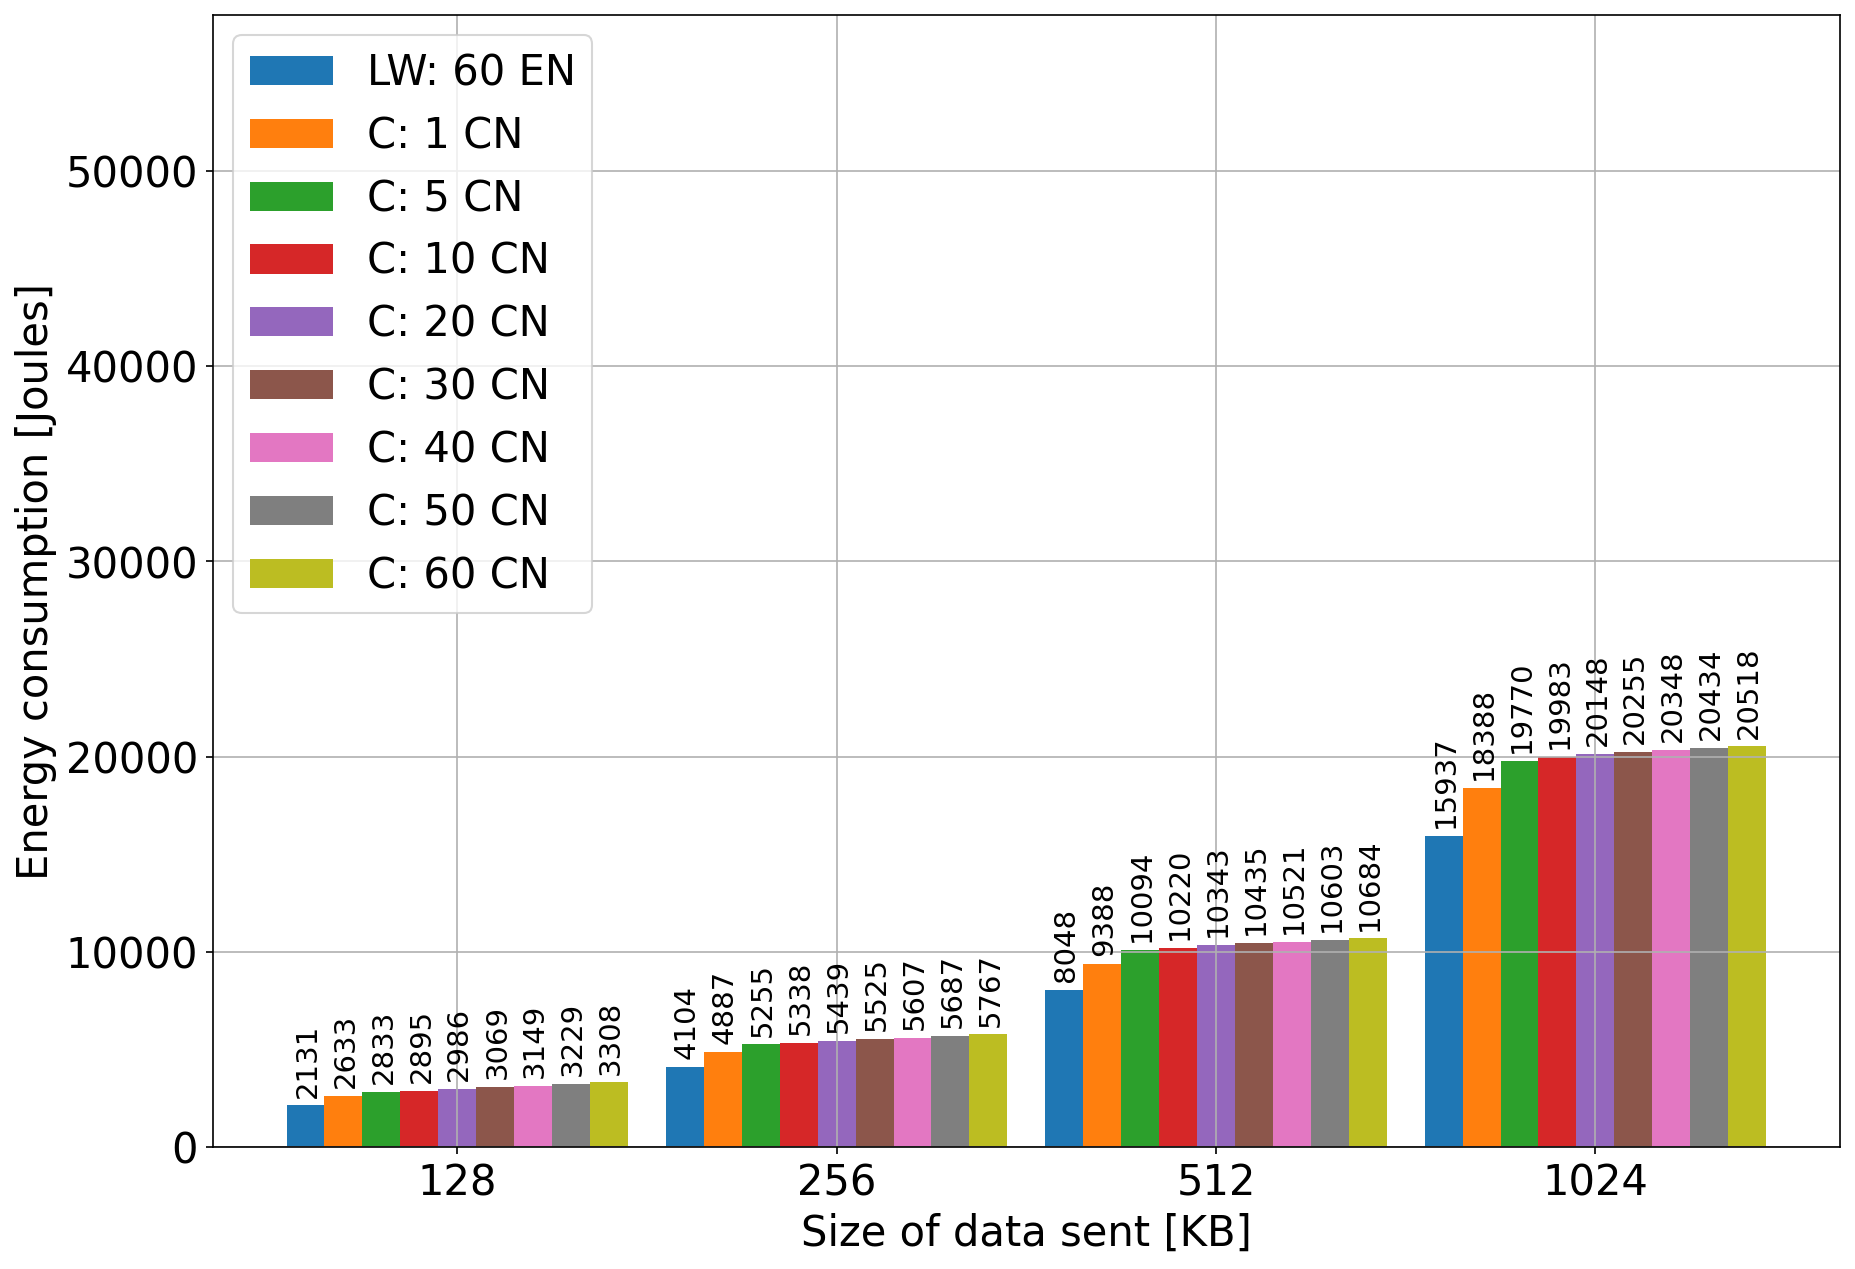

In [8]:
print(len(dev))
print(len(gw))
print(labels)
# plot_overview(labels, legend, dev, 'Size of delivered data [KB]')
colors = plot_overview_bars_eds(labels, legend, dev, 'Size of data sent [KB]', 'Energy consumption [Joules]', max_y=58000)

<!-- ### LoRaWAN GW -> sx1262 -->

In [9]:
# colors = plot_overview_bars_eds(labels, legend, dev_2, 'Size of delivered data [KB]', 'Energy consumption [Joules]', max_y=58000)

# Energy GWs

### LoRaWAN GW -> ic880a_4paths + sx1262

In [10]:
gw = [gw[0]] + [gw_2[0]] + gw[1:]
colors2 = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(colors2)
new_c = colors2[9]
colors = [colors[0], new_c] + colors[1:]

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


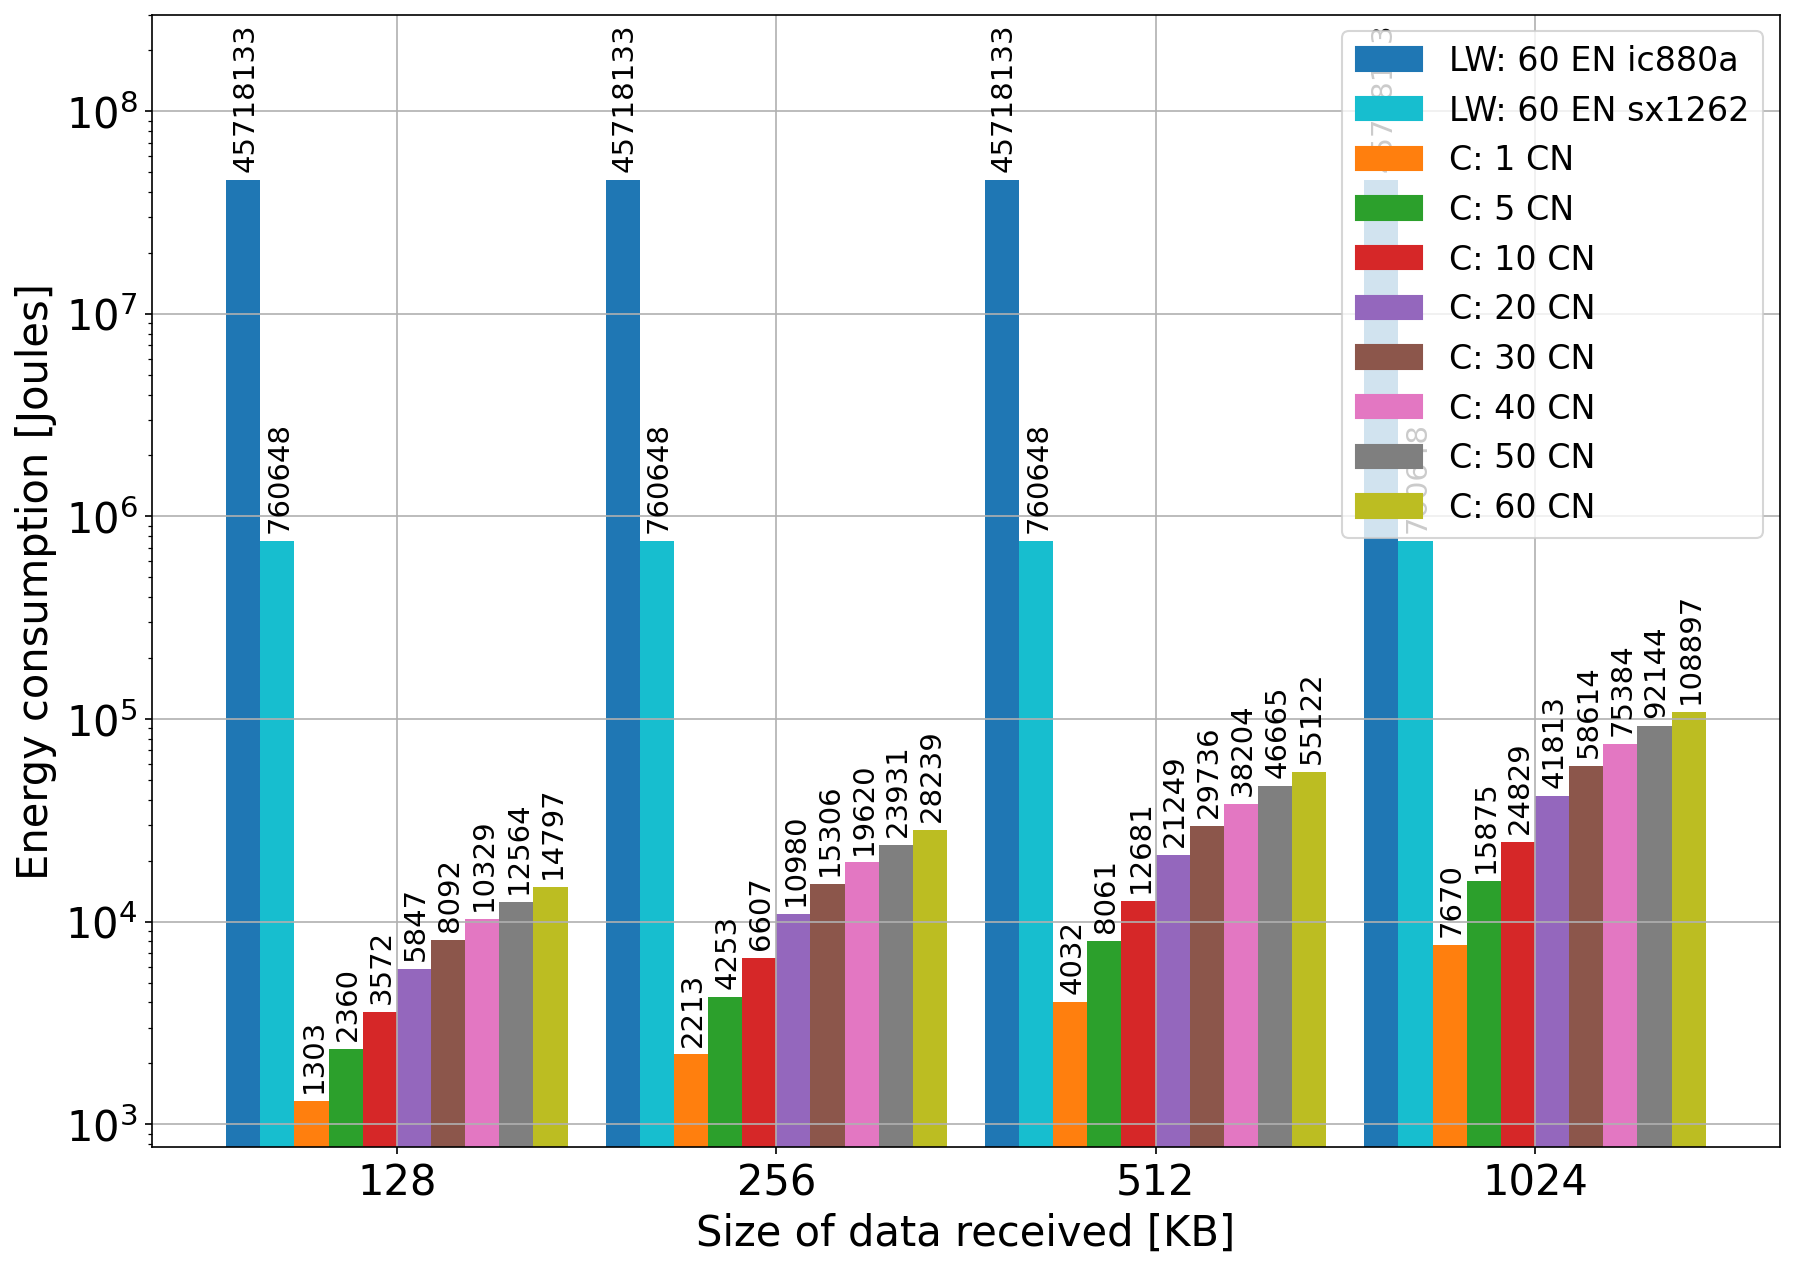

In [11]:
# plot_overview(labels, legend, gw, 'Size of requested data [KB]', sub=True)
# legend = [f'LoRaWAN: {kp.nod} ED ic880a', f'LoRaWAN: {kp.nod} ED sx1262'] + [f'CoLoRa: {x} CN' for x in kp.devs]
legend = [f'LW: {kp.nod} EN ic880a', f'LW: {kp.nod} EN sx1262'] + [f'C: {x} CN' for x in kp.devs]

plot_overview_bars_gws(labels, legend, gw, 'Size of data received [KB]', 'Energy consumption [Joules]', colors, max_y=300000000, log_scale=True, sep_lwan=False)

### LoRaWAN GW -> sx1262

In [12]:
# plot_overview_bars_gws(labels, legend, gw_2, 'Size of received data [KB]', 'Energy consumption [Joules]', colors, max_y=900000, sep_lwan=False)

# Delay EDs

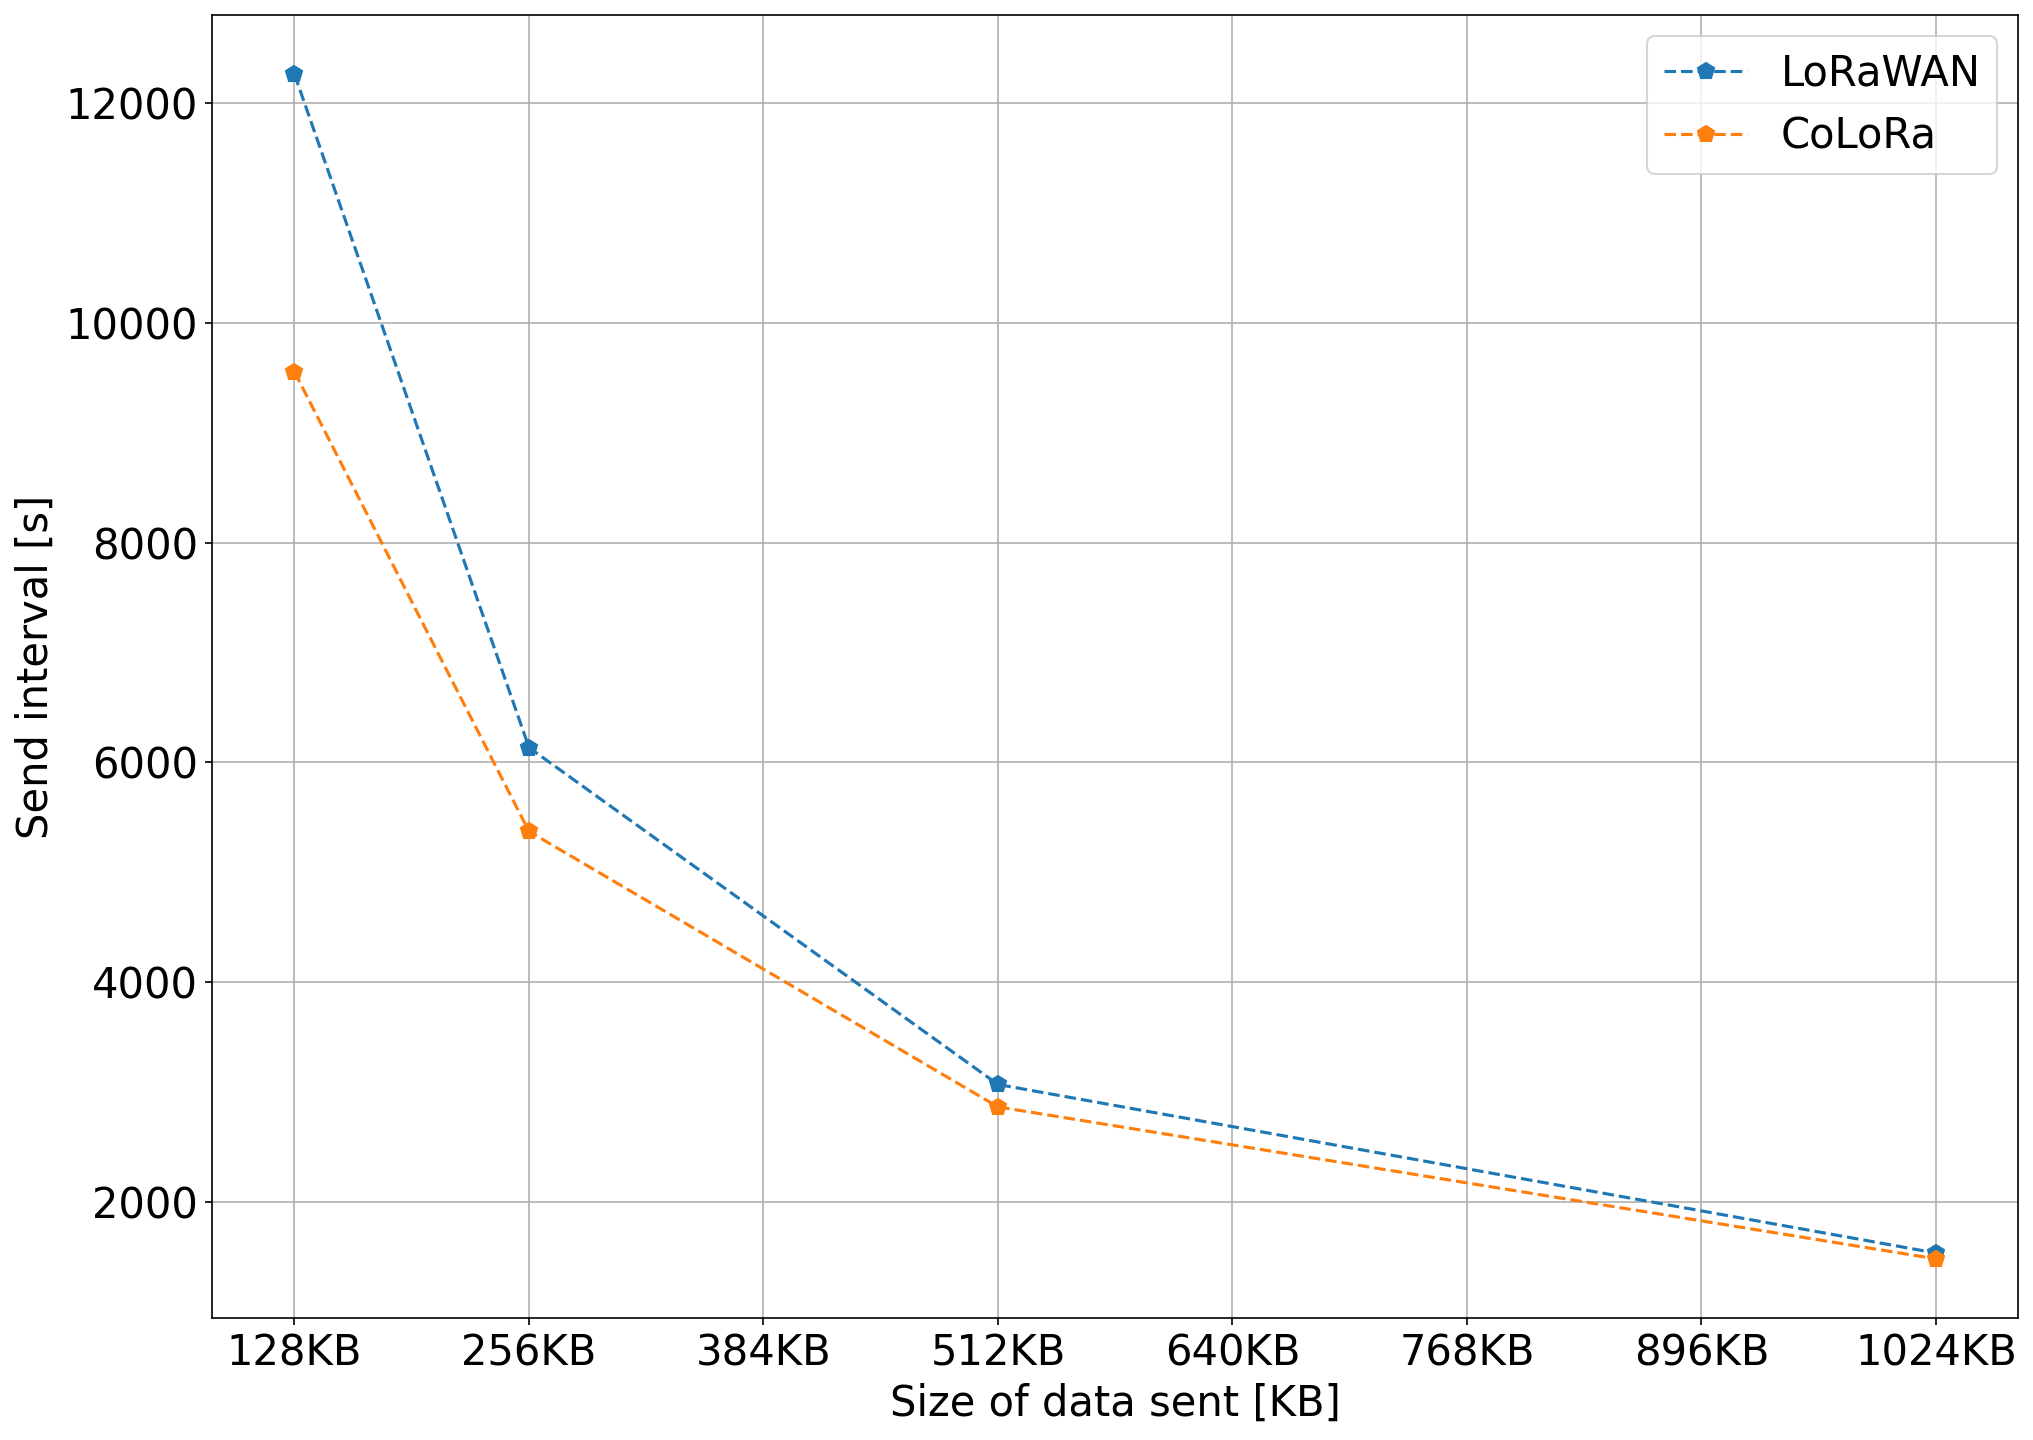

In [13]:
legend = ['LoRaWAN', 'CoLoRa']
plot_overview(labels, legend, delay[:2], 'Size of data sent [KB]', 'Send interval [s]')

In [14]:
def compare_to_lorawan(labels, gw, dev, x_label, y_label, log_scale=True, rotate_labels=False, rotate_values=False, max_y=None, lorawan=False, show_diff=False, custom_loc=None):
    f_size = 20

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    
    fig, ax = plt.subplots()
    lgw = 0
    led = 0
    if not lorawan:
        rects1 = ax.bar(x - width/2, gw, width, label='PN')
        rects2 = ax.bar(x + width/2, dev, width, label='CN')
        lgw = lgw2 = 0
    else:
        lgw = gw[0]
        lgw2 = gw[1]
        led = dev[0]
        rects1 = ax.bar(x - width/2, gw, width, label='GW - PN')
        rects2 = ax.bar(x + width/2, dev, width, label='EN - CN')
#     plt.errorbar(x + width/2, dev, yerr=dev_std, fmt='none', ecolor='black', elinewidth=1, capsize=10)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Joules')
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks(x)
    if not rotate_labels:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    if log_scale:
        ax.set_yscale('log')
    if custom_loc is None:
        ax.legend(fontsize=f_size)
    else:
        ax.legend(fontsize=f_size, loc=custom_loc)
    ax.grid(True)
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
        
    def autolabel(rects, ref=0, ref2=0):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if not rotate_values:
                ax.annotate('{}'.format(int(round(height, 0))),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 2)
                if show_diff and ref > 0 and ref != height:
                    diff = (ref / height) if ref > height else (height / ref)
                    per = (height * 100 / ref)
                    ax.annotate('{}x'.format(round(diff, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 22),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="red")
                    ax.annotate('{}%'.format(round(per, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 41),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="orange")
                if show_diff and ref2 > 0 and (ref != height and ref2 != height):
                    diff = (ref2 / height) if ref > height else (height / ref2)
                    per = (height * 100 / ref2)
                    ax.annotate('{}x'.format(round(diff, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 63),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="blue")
                    ax.annotate('{}%'.format(round(per, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 84),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="purple")
            else:
                ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(2, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, rotation=90)


    autolabel(rects1, lgw, lgw2)
    autolabel(rects2, led)

    fig.tight_layout()

    plt.show()
    
def bytes_bar(labels, data, x_label=None, y_label=None, rotate_labels=False, rotate_values=False, max_y=None):
    f_size = 20

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, data, width)
#     rects2 = ax.bar(x + width/2, dev, width, label='END-DEVICE')
#     plt.errorbar(x + width/2, dev, yerr=dev_std, fmt='none', ecolor='black', elinewidth=1, capsize=10)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Bytes sent [KB]')
    if y_label is not None:
        ax.set_ylabel(y_label)
    if x_label is not None:
        ax.set_xlabel(x_label)
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks(x)
    if not rotate_labels:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)
#     ax.set_yscale('log')
#     ax.legend(fontsize=f_size)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if not rotate_values:
                ax.annotate('{}'.format(int(round(height, 0))),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 2)
            else:
                ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(2, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, rotation=90)


    autolabel(rects1)
#     autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Performance

In [15]:
kpf = KeysWrapper(perf_folder, seq=[1, 5, 10, 20, 30, 40, 50, 60])
    
def get_perf_combined(lwan_key):
    keys_perf = [lwan_key] + kpf.get_keys('colora_max')

    bytes_perf = [round(stats_perf[lwan_key][1][1] / 1024, 0)]
    packets_perf = [stats_perf[lwan_key][1][0]]
    for key in keys_perf[1:]:
        bytes_perf.append(round(stats_perf[key][1][2] / 1024, 2))
        packets_perf.append(stats_perf[key][1][0])

    gw, dev, _ = get_avg_joules(energy_perf, keys_perf)
    return bytes_perf, packets_perf, gw, dev

## Max bytes

In [16]:
bytes_perf, packets_perf, gw, dev = get_perf_combined('lorawan_max_1')
bytes_perf_2, packets_perf_2, gw_2, dev_2 = get_perf_combined('lorawan_sx1262_max_1')
gw_2.insert(0, gw[0])
dev_2.insert(0, dev[0])

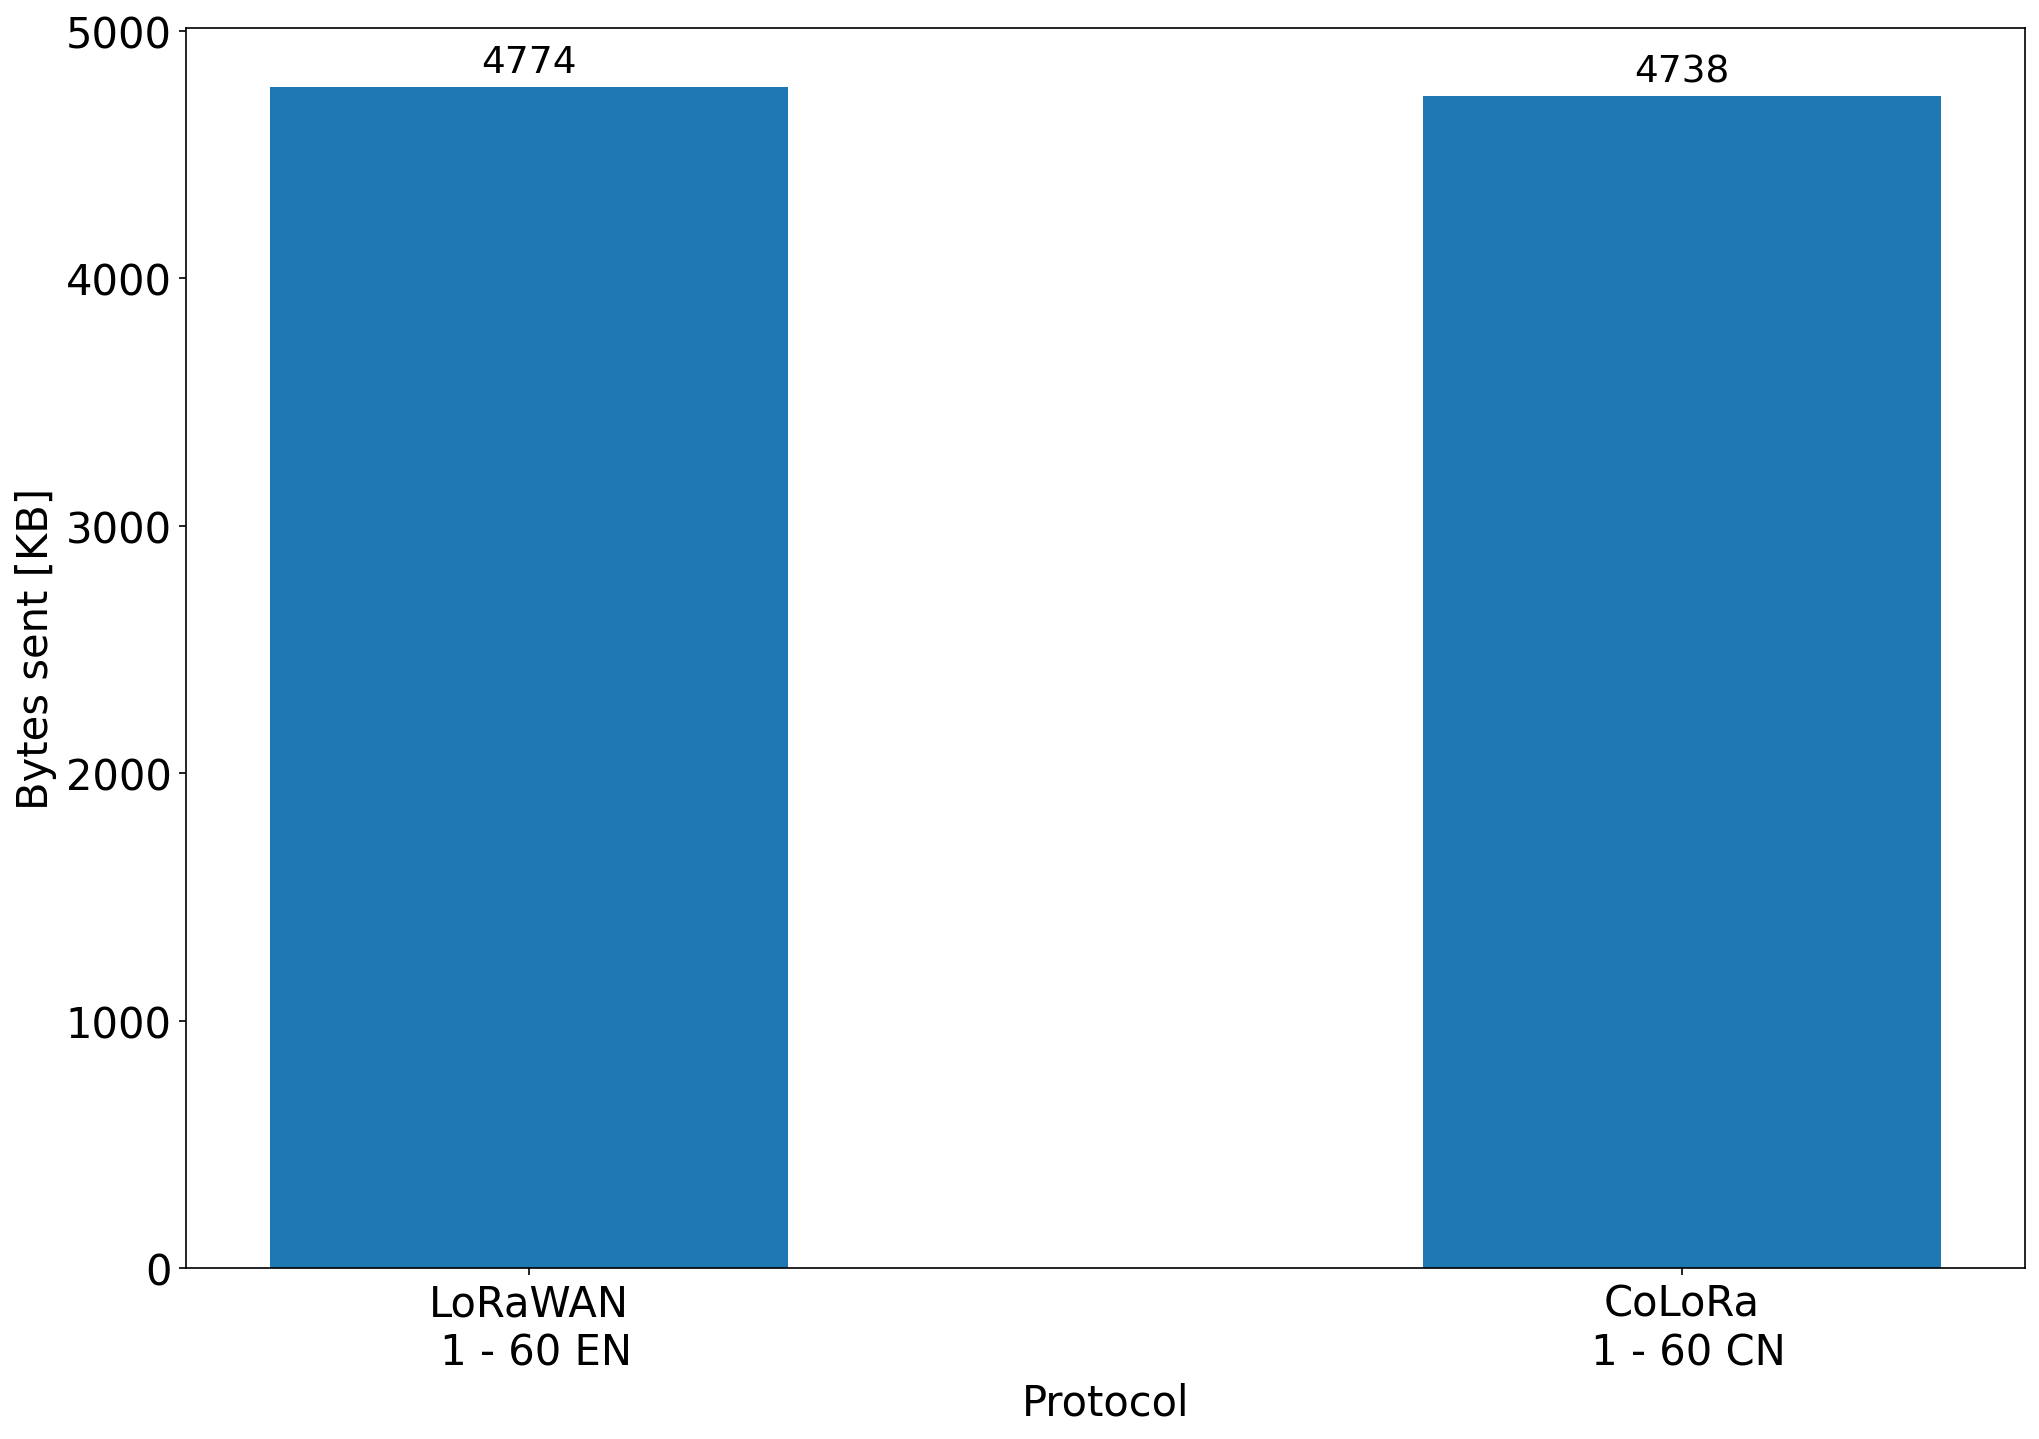

[4774.0, 4737.62, 4737.62, 4737.62, 4737.62, 4737.62, 4737.62, 4737.62, 4737.62]
99.23795559279431


In [17]:
# legend = ['LoRaWAN\n40 ED', 'CoLoRa\n1 CN', 'CoLoRa\n5 CN', 'CoLoRa\n10 CN', 'CoLoRa\n15 CN', 'CoLoRa\n20 CN']
# legend = [f'LoRaWAN\n{kpf.nod} ED'] + [f'CoLoRa\n{x} CN' for x in kpf.devs]
legend = [f'LoRaWAN\n 1 - {kpf.nod} EN'] + [f'CoLoRa\n 1 - {kpf.nod} CN']
bytes_bar(legend, bytes_perf[:2], x_label='Protocol')
print(bytes_perf)
print(bytes_perf[1]*100/bytes_perf[0])

In [18]:
# bytes_bar(legend, packets_perf, y_label='Packets sent')

<!-- ### LoRaWAN GW -> ic880a_4paths -->

In [19]:
# compare_to_lorawan(legend, gw, dev, 'Number of devices for the given protocol', 'Energy consumption [Joules]', lorawan=True, show_diff=True)

### LoRaWAN GW -> sx1262

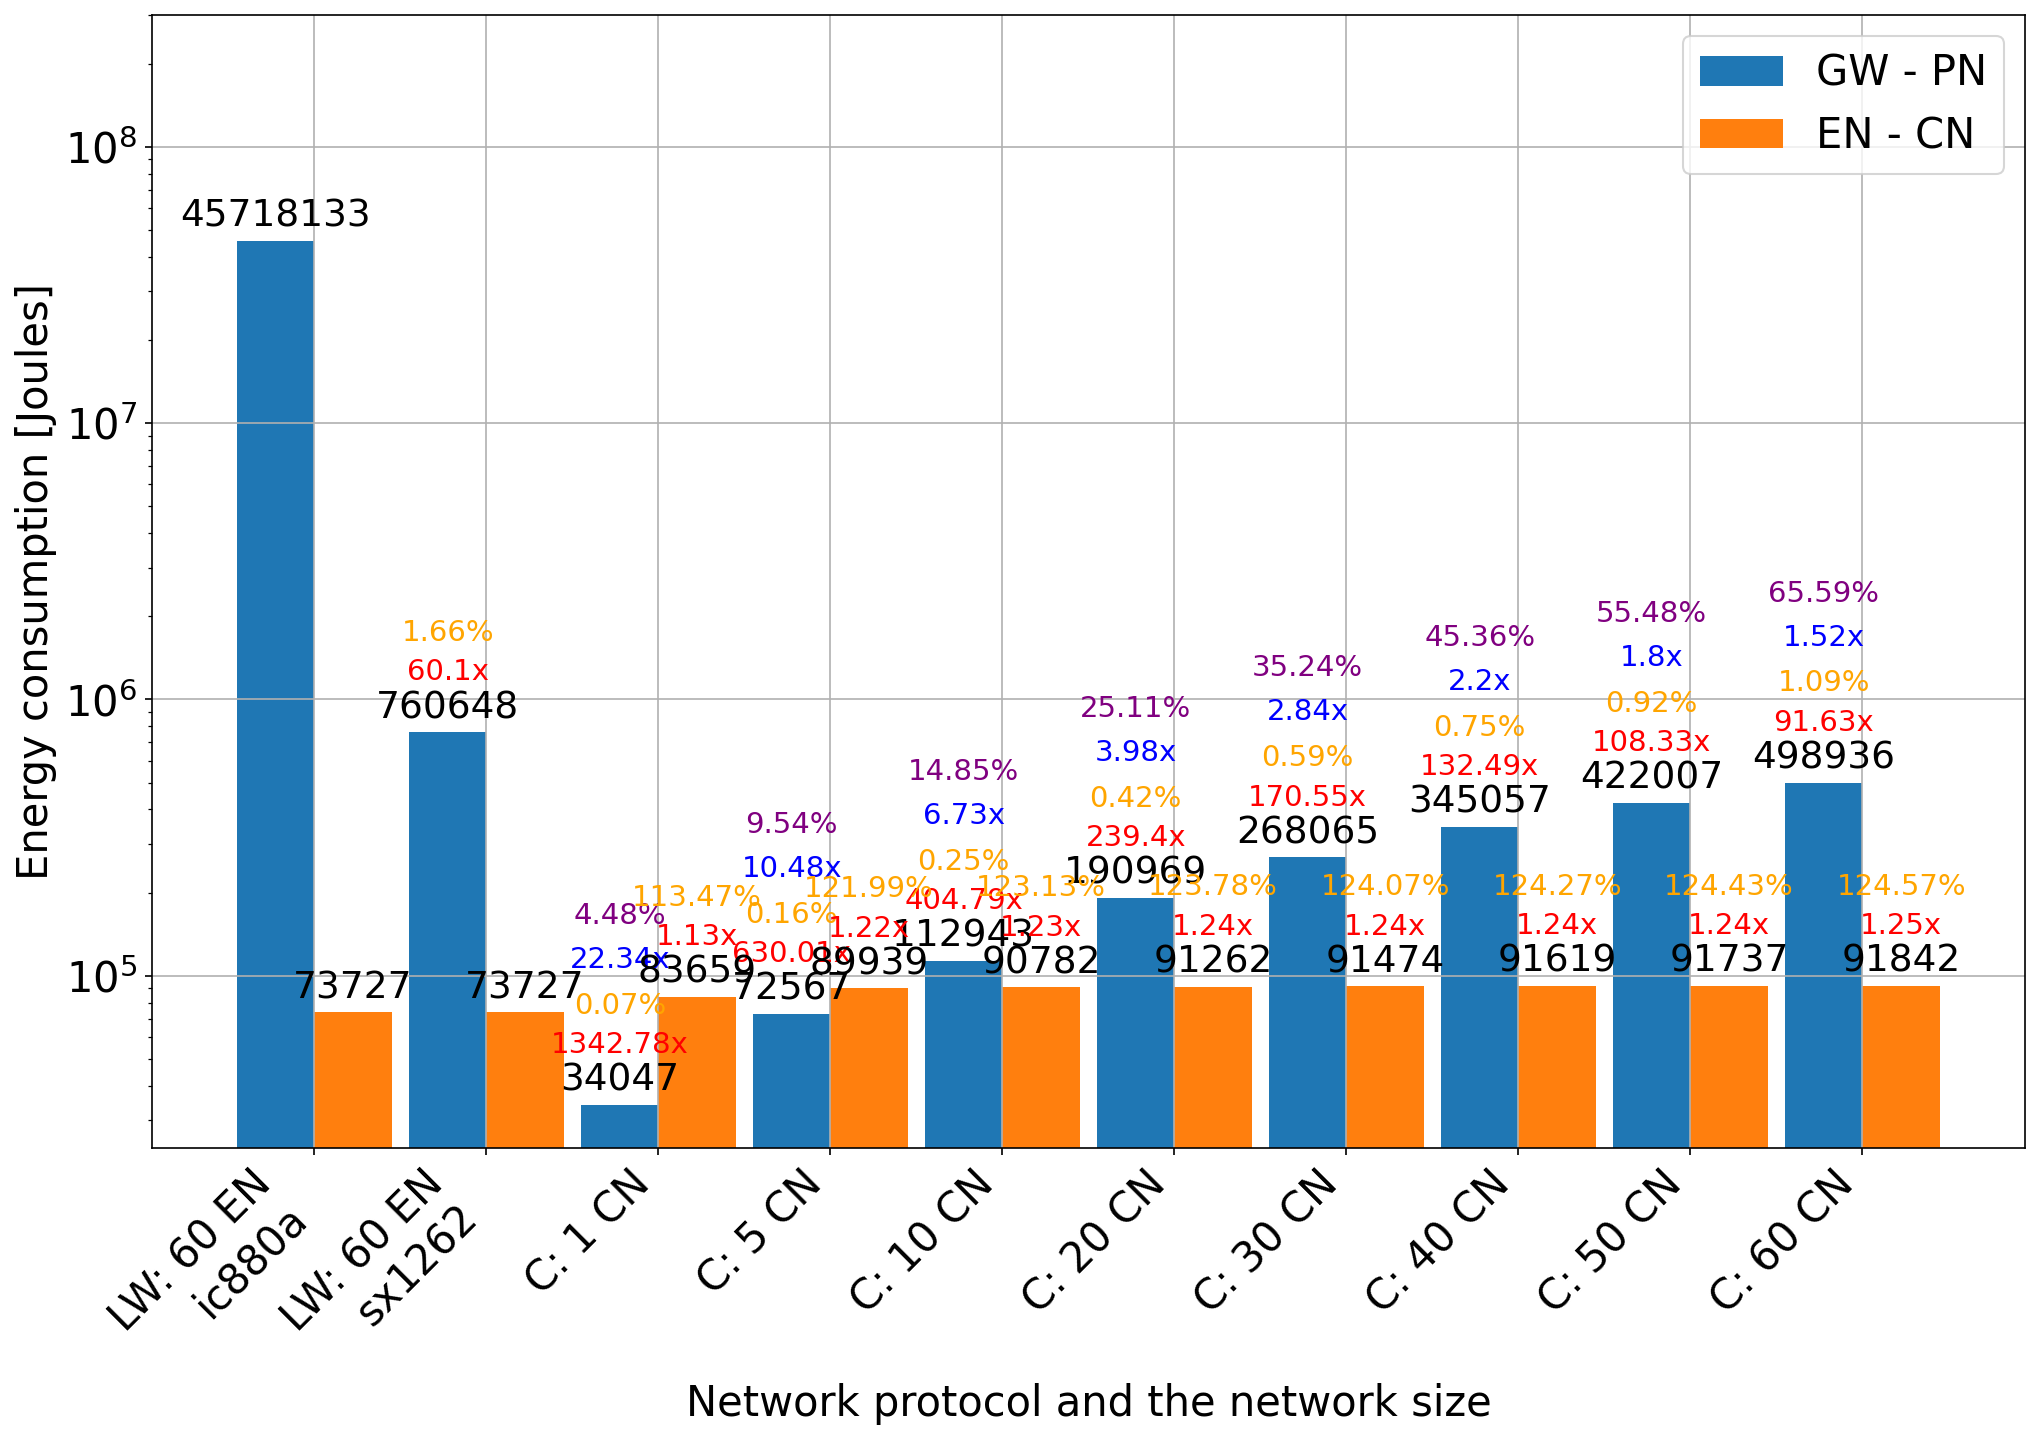

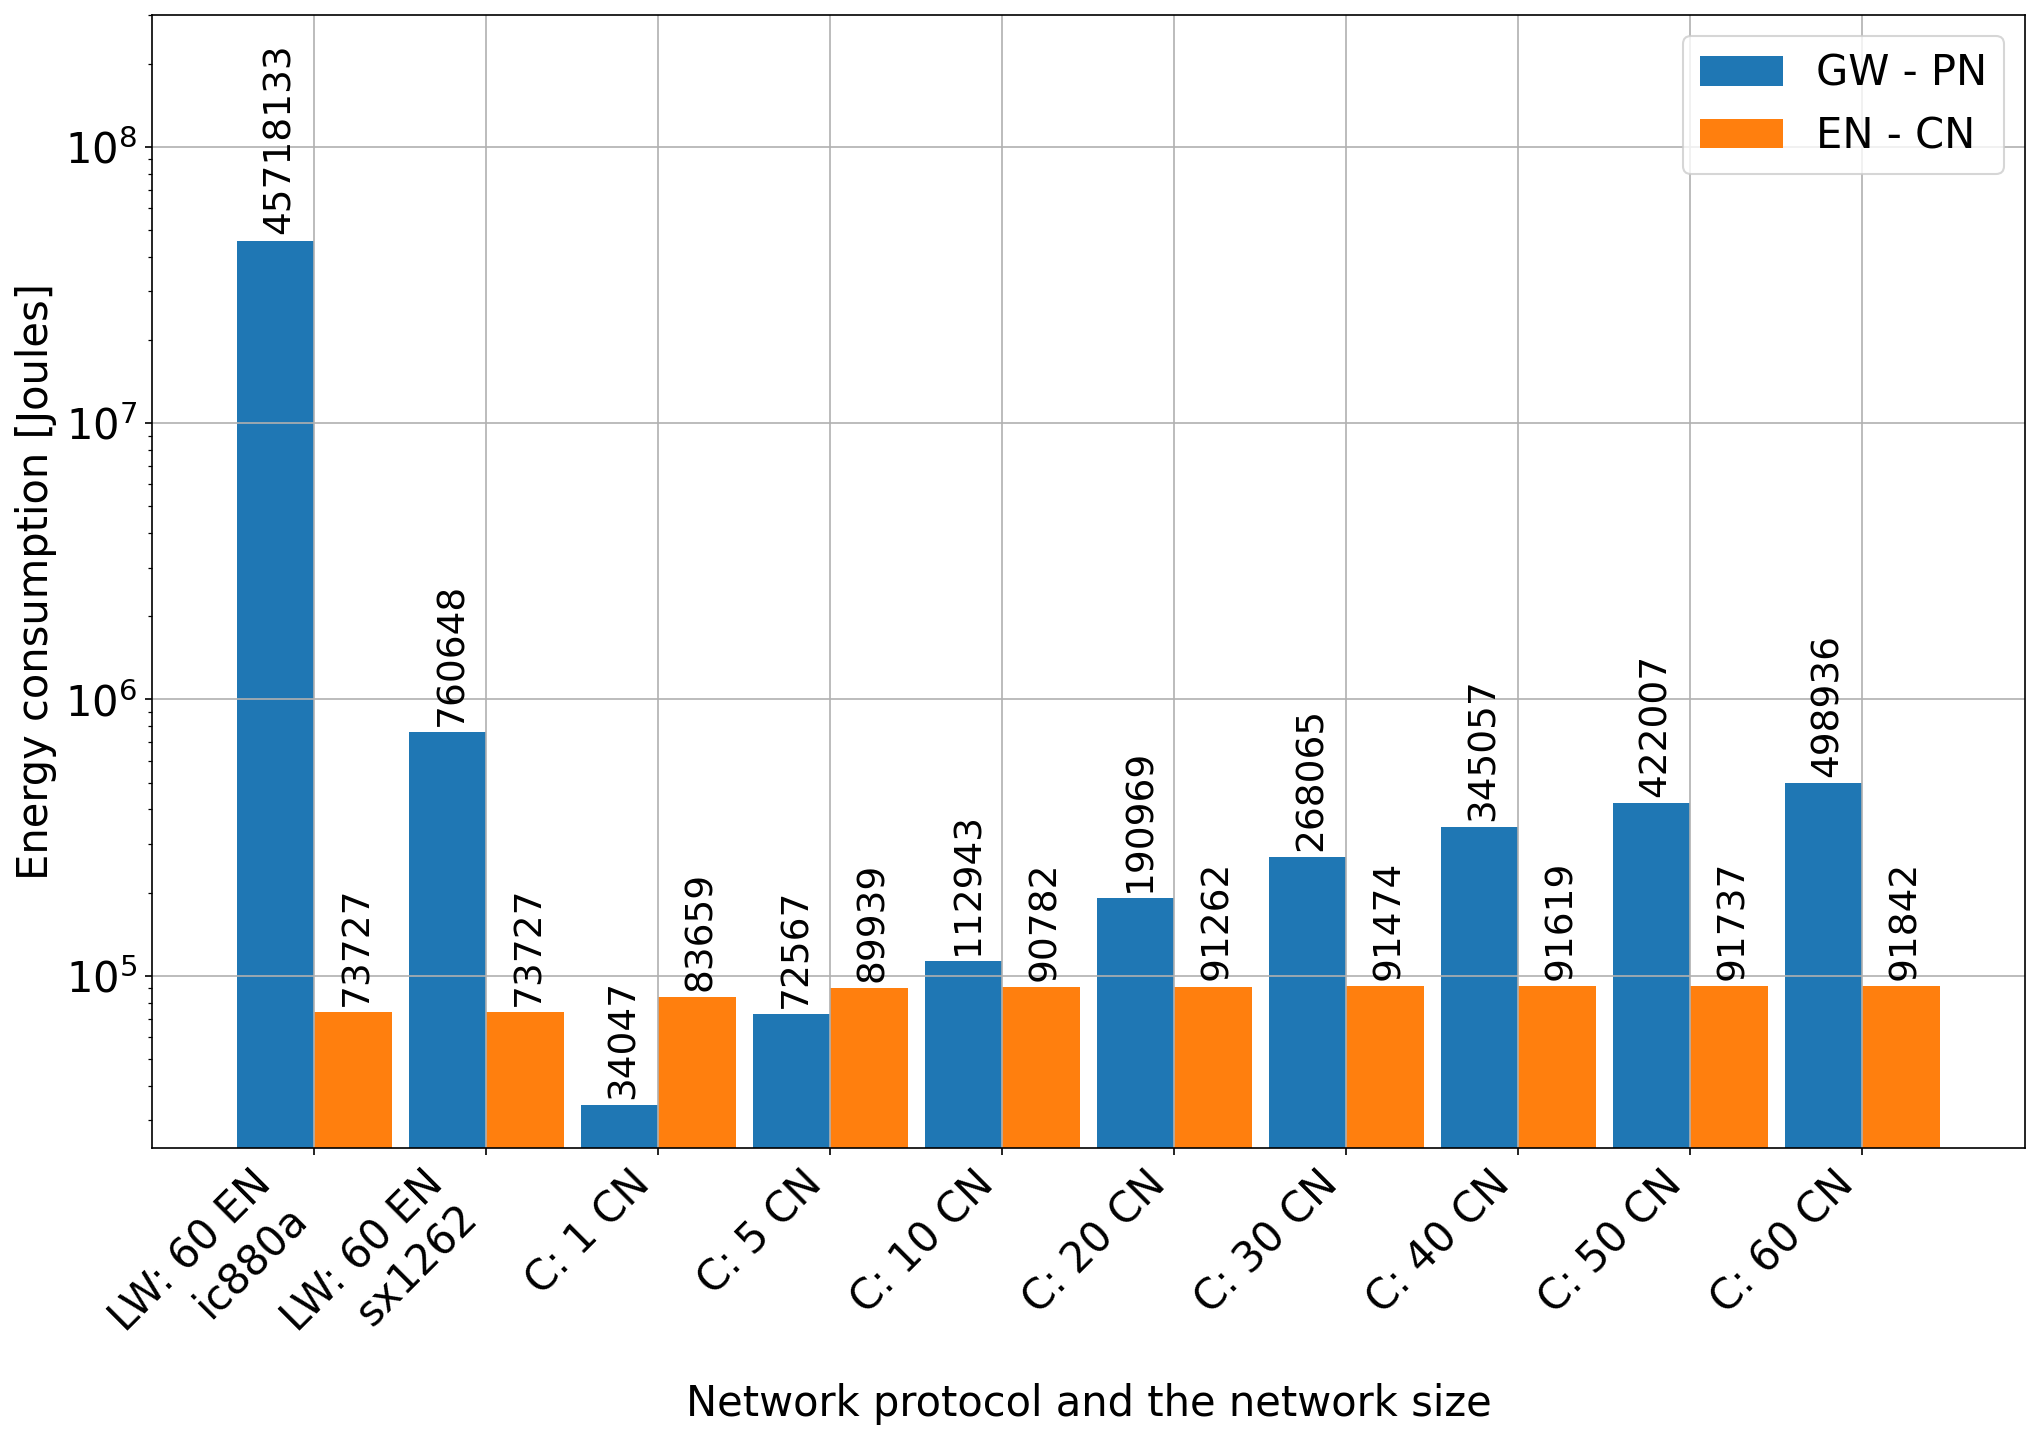

In [20]:
legend = [f'LW: {kpf.nod} EN\nic880a', f'LW: {kpf.nod} EN\nsx1262'] + [f'C: {x} CN' for x in kpf.devs]

compare_to_lorawan(legend, gw_2, dev_2, 'Network protocol and the network size', 'Energy consumption [Joules]', lorawan=True, show_diff=True, custom_loc='upper right', max_y=300000000, rotate_labels=True, rotate_values=False)
compare_to_lorawan(legend, gw_2, dev_2, 'Network protocol and the network size', 'Energy consumption [Joules]', lorawan=True, show_diff=False, custom_loc='upper right', max_y=300000000, rotate_labels=True, rotate_values=True)

In [21]:
# keys_join = []
# delay_join = []
# # for key in info_opt:
# # #     print(f'{key}: {info_opt[key]["delay"]}')
# #     keys_join.append(key)
# #     delay_join.append(info_opt[key]["delay"])
# # #     delay_join.append(key)
    
# # join_sorted = sorted(zip(delay_join, keys_join), key=lambda x: x[0])
# # for key, value in join_sorted:
# #     print(key, value)
# for key in info_join:
#     keys_join.append(key)
#     delay_join.append(info_join[key]['delay'])
    
# join_sorted = sorted(zip(delay_join, keys_join), key=lambda x: x[0])
# legend = []
# keys_join = []
# data = []
# for key, value in join_sorted:
#     legend.append(key)
#     keys_join.append(value)
#     data.append(energy_join[value][1][0])
    
# # bytes_bar(legend, data, 'Energy consumption [Joules]', 'Command send interval [s]', True)

In [22]:
def get_min_max_joules(data, keys):
    gw = []
    eds = []
    eds_stdev = []
    for key in keys:
#         tmp_key_data = data[key]
        gw.append(data[key][0][0])
        key_eds = [data[key][x][0] for x in data[key] if x >= 1]
        if len(key_eds) > 1:
            eds.append(min(key_eds))
            eds.append(max(key_eds))
        
    return gw, eds

<!-- # Balanced vs Non-balanced -->

<!-- ## 20 CN -> 1024KB -->

In [23]:
# gw_opt, dev_opt, _ = get_avg_joules(energy_opt, ['colora_1024_20_39_74'])
# gw_nbs, dev_nbs = get_min_max_joules(energy_nbs, ['colora_1024_20_39_74'])

# gw = [gw_nbs[0], gw_opt[0], gw_nbs[0]]
# dev = [dev_nbs[0], dev_opt[0], dev_nbs[1]]
# legend = ['non-balanced min', 'balanced', 'non-balanced max']
# compare_to_lorawan(legend, gw, dev, 'Schedule type', 'Energy consumption [Joules]', False)

<!-- ### Bytes sent by Parent node -->

In [24]:
# # print(stats_opt['colora_1024_20_39_74'][0][1])
# bytes_nbs_bs = []
# bytes_nbs_bs.append(round(stats_nbs['colora_1024_20_39_74'][0][1] / 1024, 2))
# bytes_nbs_bs.append(round(stats_opt['colora_1024_20_39_74'][0][1] / 1024, 2))
# bytes_bar(['non-balanced', 'balanced'], bytes_nbs_bs)

<!-- ## 40 CN -> 1024KB -->

In [25]:
# gw_opt, dev_opt, _ = get_avg_joules(energy_opt, ['colora_1024_40_75_141'])
# gw_nbs, dev_nbs = get_min_max_joules(energy_nbs, ['colora_1024_40_75_141'])

# gw = [gw_nbs[0], gw_opt[0], gw_nbs[0]]
# dev = [dev_nbs[0], dev_opt[0], dev_nbs[1]]
# legend = ['non-balanced min', 'balanced', 'non-balanced max']
# compare_to_lorawan(legend, gw, dev, 'Schedule type', 'Energy consumption [Joules]', False)

<!-- ### Bytes sent by Parent node -->

In [26]:
# bytes_nbs_bs = []
# bytes_nbs_bs.append(round(stats_nbs['colora_1024_40_75_141'][0][1] / 1024, 2))
# bytes_nbs_bs.append(round(stats_opt['colora_1024_40_75_141'][0][1] / 1024, 2))
# bytes_bar(['non-balanced', 'balanced'], bytes_nbs_bs)

# DCW effect on energy usage

In [27]:
# keys_dcw = ['colora_512_20_39_20', 'colora_512_20_39_40', 'colora_512_20_39_80']
# kdcw = KeysWrapper(dcw_folder, 20)
# kdcw2 = KeysWrapper(dcw2_folder, 20)
kdcw3 = KeysWrapper(dcw3_folder, 40)

# keys_dcw_128 = kdcw.get_keys('colora_128')
# keys_dcw_128 = ['colora_128_20_39_5', 'colora_128_20_39_10', 'colora_128_20_39_15', 'colora_128_20_39_20', 'colora_128_20_39_25', 'colora_128_20_39_30', 'colora_128_20_39_35', 'colora_128_20_39_40', 'colora_128_20_39_45', 'colora_128_20_39_50', 'colora_128_20_39_55', 'colora_128_20_39_60', 'colora_128_20_39_65', 'colora_128_20_39_70', 'colora_128_20_39_75']
# keys_dcw_128_d = kdcw2.get_keys('colora_128') 
# get_keys(dcw2_folder, 'colora_128_20')
# keys_dcw_128_d2 = kdcw3.get_keys('colora_128') 
# get_keys(dcw3_folder, 'colora_128_40')
# kdcw3.nod = 0
kdcw4 = KeysWrapper(dcw3_folder, 60, seq=[60])
keys_dcw_128_60 = kdcw4.get_keys('colora_128')

# gw_dcw, dev_dcw, _ = get_avg_joules(energy_dcw, keys_dcw)
# gw_dcw_128, dev_dcw_128, _ = get_avg_joules(energy_dcw, keys_dcw_128)
# gw_dcw_128_d, dev_dcw_128_d, _ = get_avg_joules(energy_dcw2, keys_dcw_128_d)
# gw_dcw_128_d2, dev_dcw_128_d2, _ = get_avg_joules(energy_dcw3, keys_dcw_128_d2)
gw_dcw_128_60, dev_dcw_128_60, _ = get_avg_joules(energy_dcw3, keys_dcw_128_60)

# legend = ['DCW: 20s', 'DCW: 40s', 'DCW: 80s']
# legend_128 = ['DCW: 5s', 'DCW: 10s', 'DCW: 15s', 'DCW: 20s', 'DCW: 25s', 'DCW: 30s', 'DCW: 35s', 'DCW: 40s', 'DCW: 45s', 'DCW: 50s', 'DCW: 55s', 'DCW: 60s', 'DCW: 65s', 'DCW: 70s', 'DCW: 75s']
# legend_128_d = ['DCW: 4s - Q: 1', 'DCW: 7s - Q: 2', 'DCW: 11s - Q: 3', 'DCW: 14s - Q: 4', 'DCW: 17s - Q: 5', 'DCW: 21s - Q: 6', 'DCW: 24s - Q: 7', 'DCW: 27s - Q: 8', 'DCW: 31s - Q: 9', 'DCW: 34s - Q: 10', 'DCW: 37s - Q: 11', 'DCW: 41s - Q: 12', 'DCW: 44s - Q: 13', 'DCW: 47s - Q: 14', 'DCW: 51s - Q: 15', 'DCW: 54s - Q: 16', 'DCW: 57s - Q: 17', 'DCW: 61s - Q: 18', 'DCW: 64s - Q: 19', 'DCW: 67s - Q: 20']
# legend_128_d2 = ['CW: 7s - Q: 2', 'CW: 11s - Q: 3', 'CW: 14s - Q: 4', 'CW: 17s - Q: 5', 'CW: 21s - Q: 6', 'CW: 24s - Q: 7', 'CW: 27s - Q: 8', 'CW: 31s - Q: 9', 'CW: 34s - Q: 10', 'CW: 37s - Q: 11', 'CW: 41s - Q: 12', 'CW: 44s - Q: 13', 'CW: 47s - Q: 14', 'CW: 51s - Q: 15', 'CW: 54s - Q: 16', 'CW: 57s - Q: 17', 'CW: 61s - Q: 18', 'CW: 64s - Q: 19', 'CW: 67s - Q: 20', 'CW: 71s - Q: 21', 'CW: 74s - Q: 22', 'CW: 77s - Q: 23', 'CW: 81s - Q: 24', 'CW: 84s - Q: 25', 'CW: 87s - Q: 26', 'CW: 91s - Q: 27', 'CW: 94s - Q: 28', 'CW: 98s - Q: 29', 'CW: 101s - Q: 30', 'CW: 104s - Q: 31', 'CW: 108s - Q: 32', 'CW: 111s - Q: 33', 'CW: 114s - Q: 34', 'CW: 118s - Q: 35', 'CW: 121s - Q: 36', 'CW: 124s - Q: 37', 'CW: 128s - Q: 38', 'CW: 131s - Q: 39', 'CW: 134s - Q: 40']
legend_128_60 = ['DCW: 7s - Q: 2', 'DCW: 11s - Q: 3', 'DCW: 14s - Q: 4', 'DCW: 17s - Q: 5', 'DCW: 21s - Q: 6', 'DCW: 24s - Q: 7', 'DCW: 27s - Q: 8', 'DCW: 31s - Q: 9', 'DCW: 34s - Q: 10', 'DCW: 37s - Q: 11', 'DCW: 41s - Q: 12', 'DCW: 44s - Q: 13', 'DCW: 47s - Q: 14', 'DCW: 51s - Q: 15', 'DCW: 54s - Q: 16', 'DCW: 57s - Q: 17', 'DCW: 61s - Q: 18', 'DCW: 64s - Q: 19', 'DCW: 67s - Q: 20', 'DCW: 71s - Q: 21', 'DCW: 74s - Q: 22', 'DCW: 77s - Q: 23', 'DCW: 81s - Q: 24', 'DCW: 84s - Q: 25', 'DCW: 87s - Q: 26', 'DCW: 91s - Q: 27', 'DCW: 94s - Q: 28', 'DCW: 98s - Q: 29', 'DCW: 101s - Q: 30', 'DCW: 104s - Q: 31', 'DCW: 108s - Q: 32', 'DCW: 111s - Q: 33', 'DCW: 114s - Q: 34', 'DCW: 118s - Q: 35', 'DCW: 121s - Q: 36', 'DCW: 124s - Q: 37', 'DCW: 128s - Q: 38', 'DCW: 131s - Q: 39', 'DCW: 134s - Q: 40', 'DCW: 138s - Q: 41', 'DCW: 141s - Q: 42', 'DCW: 144s - Q: 43', 'DCW: 148s - Q: 44', 'DCW: 151s - Q: 45', 'DCW: 154s - Q: 46', 'DCW: 158s - Q: 47', 'DCW: 161s - Q: 48', 'DCW: 164s - Q: 49', 'DCW: 168s - Q: 50', 'DCW: 171s - Q: 51', 'DCW: 174s - Q: 52', 'DCW: 178s - Q: 53', 'DCW: 181s - Q: 54', 'DCW: 184s - Q: 55', 'DCW: 188s - Q: 56', 'DCW: 191s - Q: 57', 'DCW: 195s - Q: 58', 'DCW: 198s - Q: 59', 'DCW: 201s - Q: 60']
legend_128_60_s = ['7|2', '11|3', '14|4', '17|5', '21|6', '24|7', '27|8', '31|9', '34|10', '37|11', '41|12', '44|13', '47|14', '51|15', '54|16', '57|17', '61|18', '64|19', '67|20', '71|21', '74|22', '77|23', '81|24', '84|25', '87|26', '91|27', '94|28', '98|29', '101|30', '104|31', '108|32', '111|33', '114|34', '118|35', '121|36', '124|37', '128|38', '131|39', '134|40', '138|41', '141|42', '144|43', '148|44', '151|45', '154|46', '158|47', '161|48', '164|49', '168|50', '171|51', '174|52', '178|53', '181|54', '184|55', '188|56', '191|57', '195|58', '198|59', '201|60']

# delay_dcw = [info_dcw[x]['delay'] for x in keys_dcw]
# delay_dcw_128 = [info_dcw[x]['delay'] for x in keys_dcw_128]
# delay_dcw_128_d = [info_dcw2[x]['delay'] for x in keys_dcw_128_d]
# delay_dcw_128_d2 = [info_dcw3[x]['delay'] for x in keys_dcw_128_d2]
delay_dcw_128_60 = [info_dcw3[x]['delay'] for x in keys_dcw_128_60]

## Energy usage

### 512KB

In [28]:
# compare_to_lorawan(legend, gw_dcw, dev_dcw, False)

<!-- ### 128KB, 20CN - 5s steps for DCW2 -->

In [29]:
# compare_to_lorawan(legend_128, gw_dcw_128, dev_dcw_128, 'Collect command window size [s]', 'Energy consumption [Joules]', False, True, True, 23000)

<!-- ### 128KB, 20CN - 1 more device each DCW3 -->

In [30]:
# compare_to_lorawan(legend_128_d, gw_dcw_128_d, dev_dcw_128_d, 'Collect command window size [s]', 'Energy consumption [Joules]', False, True, True, 23000)

<!-- ### 128KB, 40CN - 1 more device each DCW4 -->

In [31]:
# compare_to_lorawan(legend_128_d2, gw_dcw_128_d2, dev_dcw_128_d2, 'Collect command window size [s]', 'Energy consumption [Joules]', False, True, True, 30000)

### 128KB, 60CN - 1 more device each DCW4

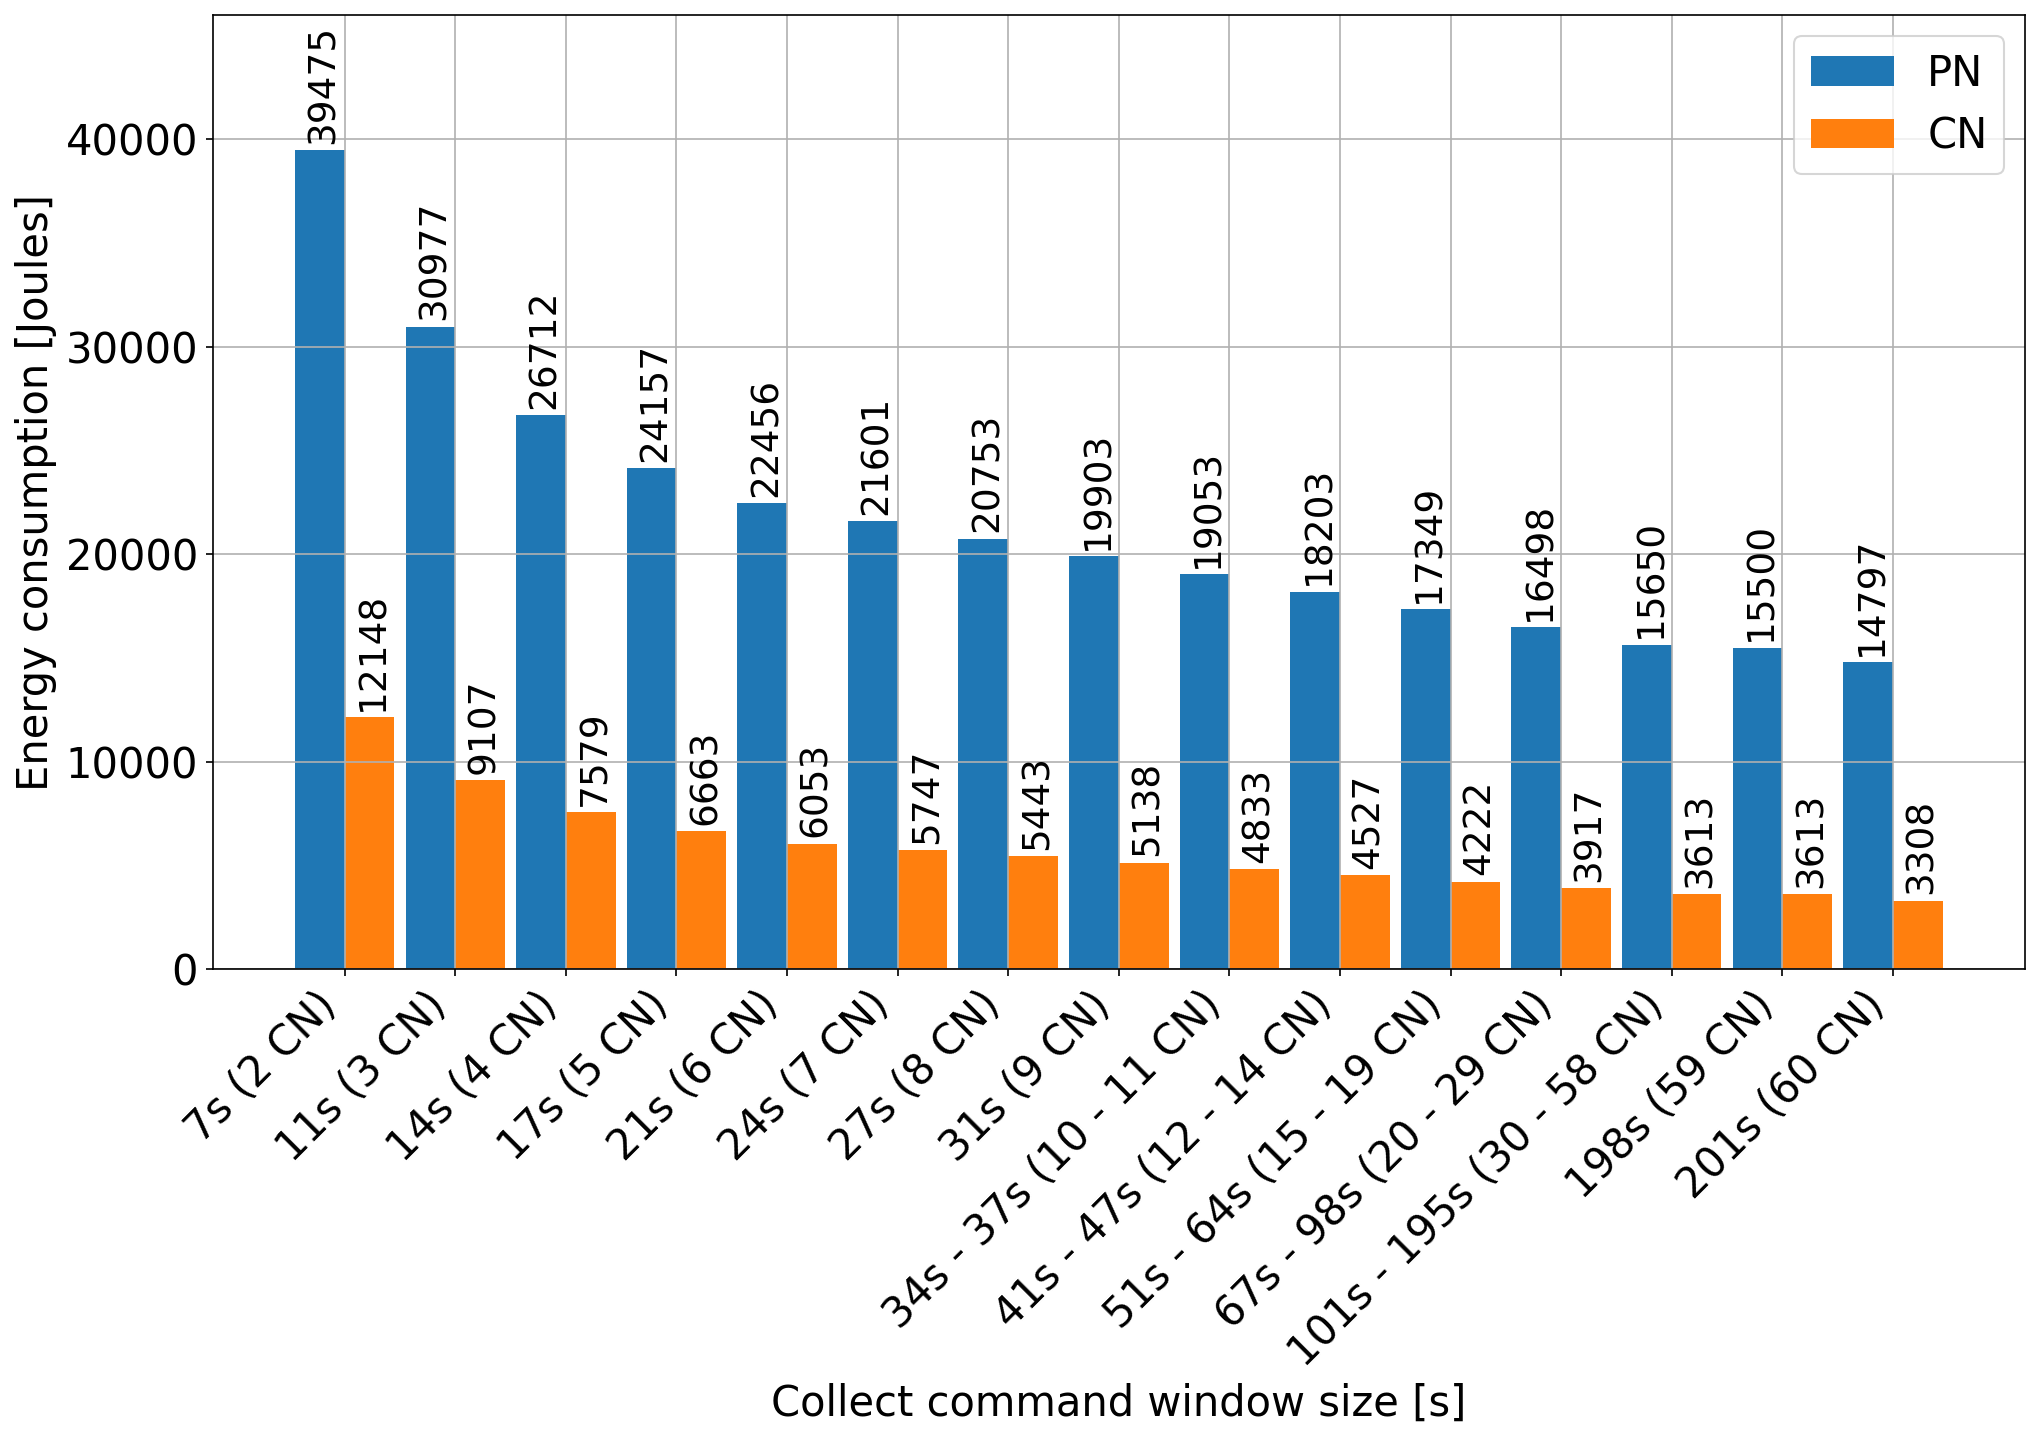

In [32]:
prev_val_gw = 0
prev_val_dev = 0
gw_dcw_simple = []
dev_dcw_simple = []
labels_simple = []
labels_index = 0
for index in range(0, len(gw_dcw_128_60)):
    if prev_val_gw == 0:
        gw_dcw_simple.append(gw_dcw_128_60[index])
        dev_dcw_simple.append(dev_dcw_128_60[index])
        labels_simple.append(legend_128_60_s[index])
        prev_val_gw = gw_dcw_128_60[index]
        prev_val_dev = dev_dcw_128_60[index]
        continue
    
    if int(prev_val_gw) - 10 <= int(gw_dcw_128_60[index]) <= int(prev_val_gw) + 10:
        labels_simple[labels_index] += f'#{legend_128_60_s[index]}'
    else:
        gw_dcw_simple.append(gw_dcw_128_60[index])
        dev_dcw_simple.append(dev_dcw_128_60[index])
        labels_simple.append(legend_128_60_s[index])
        prev_val_gw = gw_dcw_128_60[index]
        prev_val_dev = dev_dcw_128_60[index]
        labels_index += 1

final_labels = []
for index in range(0, len(labels_simple)):
    if labels_simple[index].find('#') > 0:
        tmp_label = labels_simple[index].split('#')
        label = f'{tmp_label[0].split("|")[0]}s - {tmp_label[len(tmp_label) - 1].split("|")[0]}s ({tmp_label[0].split("|")[1]} - {tmp_label[len(tmp_label) - 1].split("|")[1]} CN)'
    else:
        label = f'{labels_simple[index].split("|")[0]}s ({labels_simple[index].split("|")[1]} CN)'
        
    final_labels.append(label)

# compare_to_lorawan(legend_128_60, gw_dcw_128_60, dev_dcw_128_60, 'Collect command window size [s]', 'Energy consumption [Joules]', False, True, True, 45000)
compare_to_lorawan(final_labels, gw_dcw_simple, dev_dcw_simple, 'Collect command window size [s]', 'Energy consumption [Joules]', False, True, True, 46000)

## Send interval

<!-- ### 512KB -->

In [33]:
# bytes_bar(legend, delay_dcw, 'Command send interval [s]', 'Data Collection window size [s]' , False)
# bytes_bar(legend2, delay_dcw2, 'Command send interval [s]', 'Data Collection window size [s]' , False)

<!-- ### 128KB, 20CN - 5s steps for DCW -->

In [34]:
# bytes_bar(legend_128, delay_dcw_128, 'Collect command window size [s]', 'Command send interval [s]' , True, rotate_values=True, max_y=10700)

<!-- ### 128KB, 20CN - 1 more device each DCW -->

In [35]:
# bytes_bar(legend_128_d, delay_dcw_128_d, 'Collect command window size [s]', 'Command send interval [s]', True, rotate_values=True, max_y=10700)

<!-- ### 128KB, 40CN - 1 more device each DCW -->

In [36]:
# bytes_bar(legend_128_d2, delay_dcw_128_d2, 'Collect command window size [s]', 'Command send interval [s]', True, rotate_values=True, max_y=10700)

### 128KB, 60CN - 1 more device each DCW

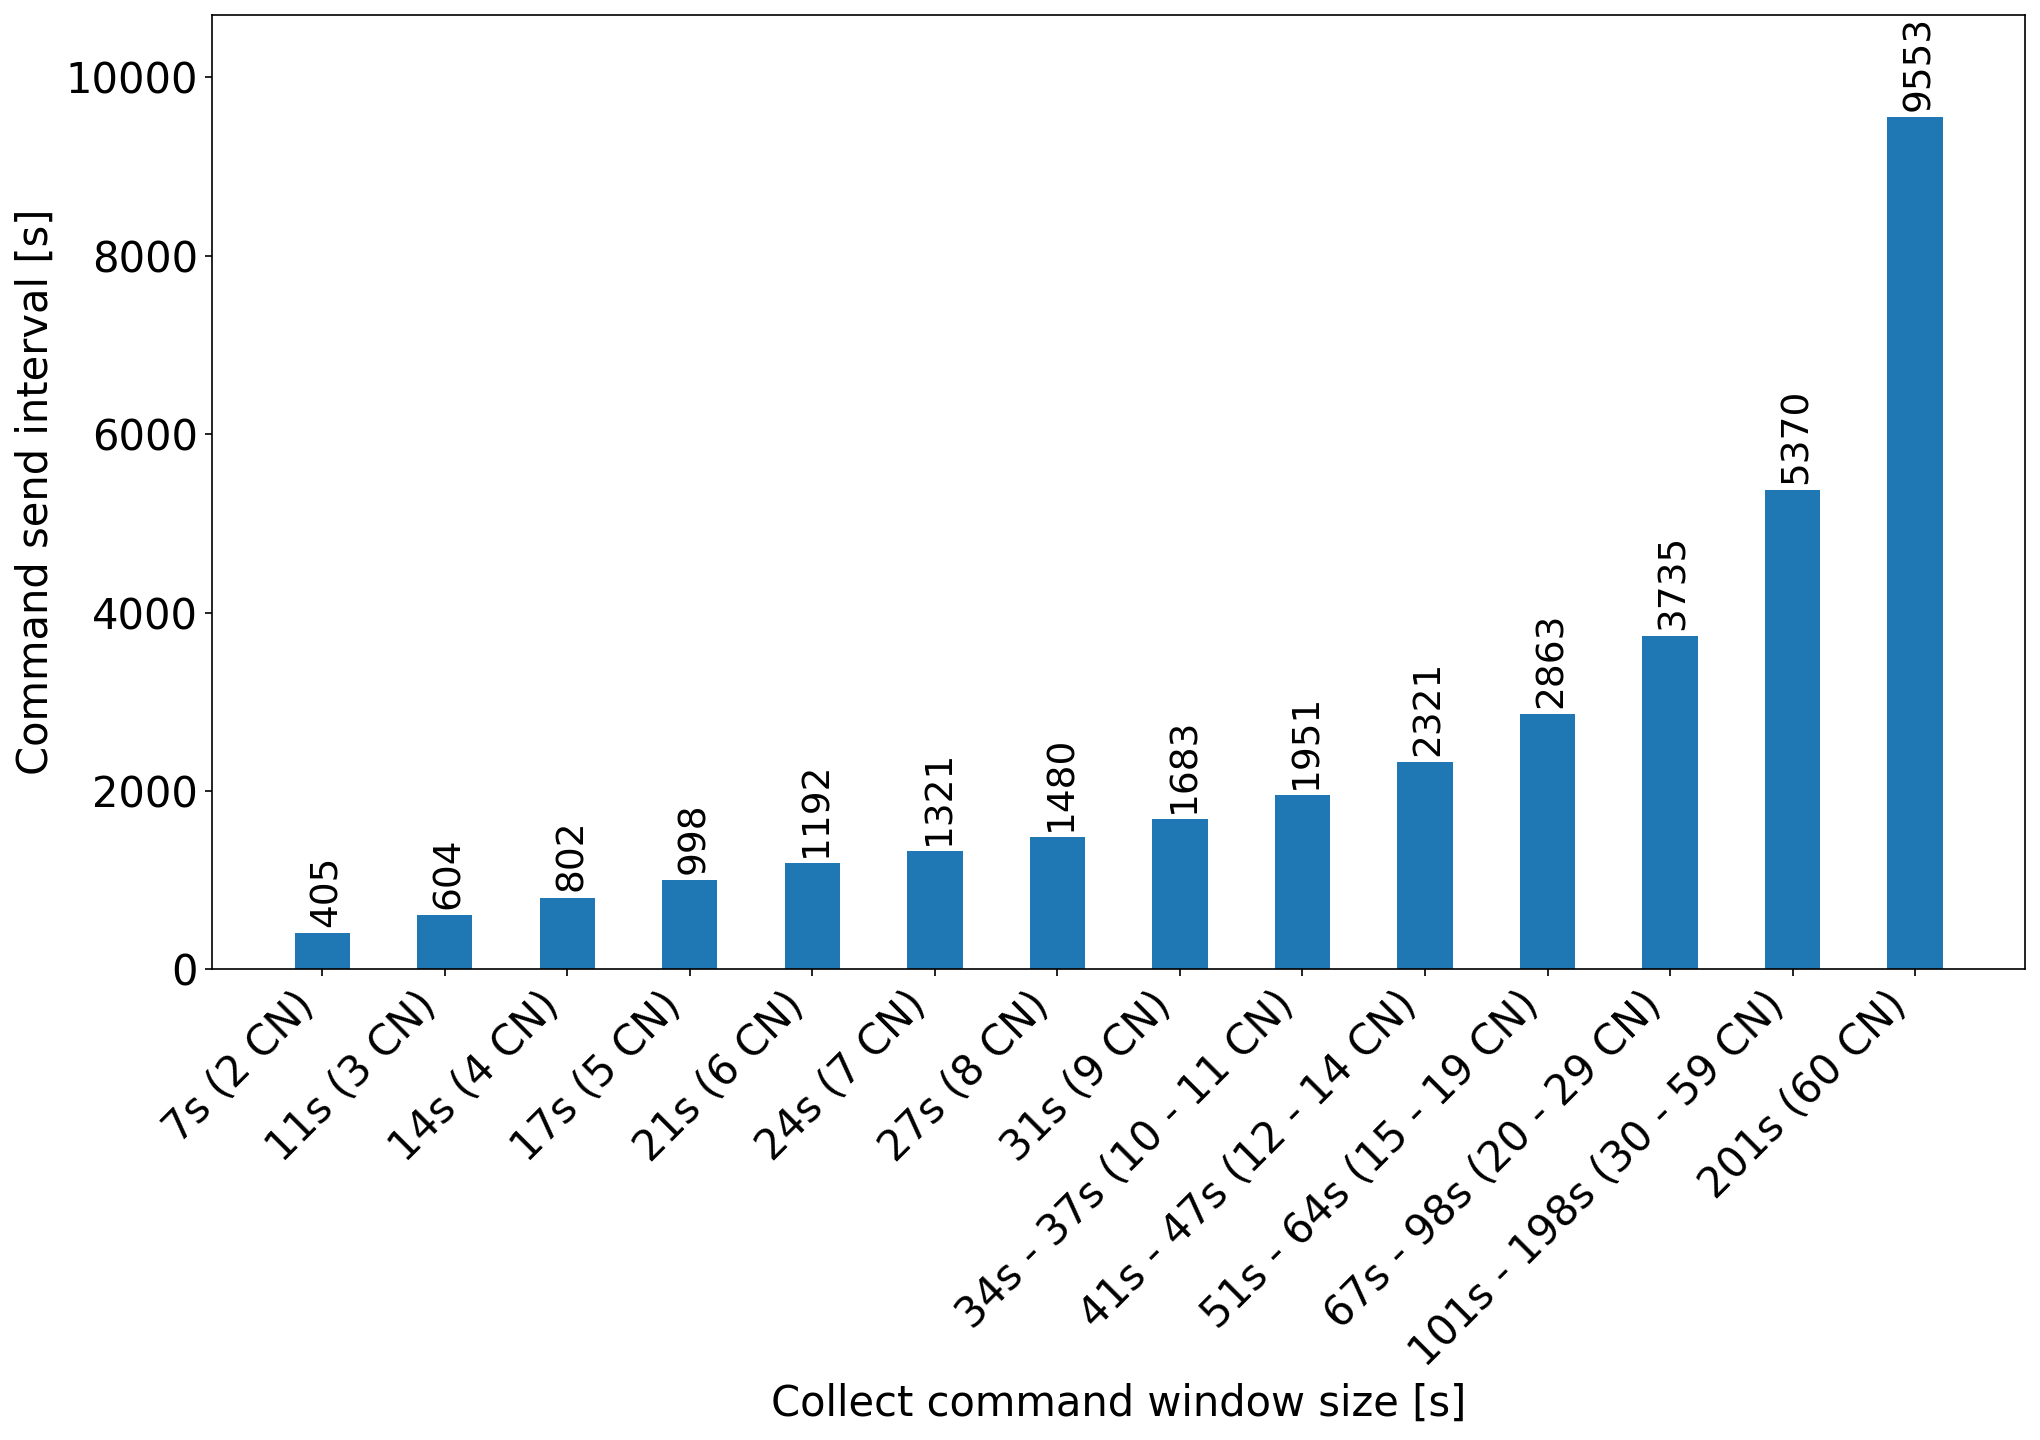

In [37]:
prev_val_delay = 0
delay_simple = []
labels_d_simple = []
labels_d_index = 0
for index in range(0, len(delay_dcw_128_60)):
    if prev_val_delay == 0:
        delay_simple.append(delay_dcw_128_60[index])
        labels_d_simple.append(legend_128_60_s[index])
        prev_val_delay = delay_dcw_128_60[index]
        continue
    
    if int(prev_val_delay) - 10 <= int(delay_dcw_128_60[index]) <= int(prev_val_delay) + 10:
        labels_d_simple[labels_d_index] += f'#{legend_128_60_s[index]}'
    else:
        delay_simple.append(delay_dcw_128_60[index])
        labels_d_simple.append(legend_128_60_s[index])
        prev_val_delay = delay_dcw_128_60[index]
        labels_d_index += 1

final_d_labels = []
for index in range(0, len(labels_d_simple)):
    if labels_d_simple[index].find('#') > 0:
        tmp_label = labels_d_simple[index].split('#')
        label = f'{tmp_label[0].split("|")[0]}s - {tmp_label[len(tmp_label) - 1].split("|")[0]}s ({tmp_label[0].split("|")[1]} - {tmp_label[len(tmp_label) - 1].split("|")[1]} CN)'
    else:
        label = f'{labels_d_simple[index].split("|")[0]}s ({labels_d_simple[index].split("|")[1]} CN)'
        
    final_d_labels.append(label)

# bytes_bar(legend_128_60_s, delay_dcw_128_60, 'Collect command window size [s]', 'Command send interval [s]', True, rotate_values=True, max_y=10700)
bytes_bar(final_d_labels, delay_simple, 'Collect command window size [s]', 'Command send interval [s]', True, rotate_values=True, max_y=10700)